# Homework 9

## Utilities 

In [1]:
#Imports Libraries 
# complex networks package - guide https://networkx.org/ 
import networkx as nx

# visualization packages - https://matplotlib.org/ 
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.drawing.nx_agraph import graphviz_layout

# n-dinsional array tool - https://numpy.org/ 
import numpy as np

#import pygraphviz
import seaborn as sns

import matplotlib.colors as mcolors

import scipy as sc

from scipy.io import mmread

from typing import Iterable

import sklearn.manifold as sk

import sklearn.cluster as skc

import sklearn.decomposition as skd
import pandas as pd

from node2vec import Node2Vec
# for Notebook
%matplotlib inline

## Question 2

### Ingesting the data 

In [2]:
df_nodes = pd.read_csv('/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/HW9/nodes.csv')
df_street = pd.read_csv('/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/HW9/streets.csv')
df_nodes.shape #Shows the head of the data


(4589, 8)

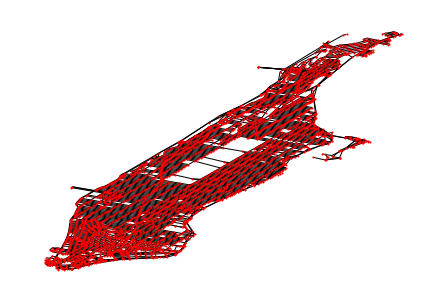

In [3]:
G = nx.Graph() #Creates the empty graph 
for index, row in df_nodes.iterrows(): 
    G.add_node(row['osmid'], pos=(row['x'], row['y'])) #Appends the graph G with the nodes
for index, row in df_street.iterrows():
    G.add_edge(row['u'], row['v'], weight=row['length']) #Appends the graph G with the length for the weights 
    
G.remove_edges_from(nx.selfloop_edges(G)) #Removes the self loops from the graph 

plt.figure() #Creates the figure 
pos = nx.get_node_attributes(G, "pos") #Gets the positional arguement 
nx.draw(G,pos, with_labels=False, node_size=1, node_color='red') #Plots the graph 
plt.show() #Shows the figure 

### skip2gram approach

In [4]:

node2vec = Node2Vec(G, dimensions=32, walk_length=50, num_walks=100 , workers = 8) #Uses the node2vec library 


Generating walks (CPU: 4): 100%|██████████| 13/13 [01:37<00:00,  7.50s/it]


In [5]:
model = node2vec.fit() # https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

### Matrix factorization

In [24]:
node_embeddings = model.wv.vectors #Matrix Factorization

### Plot Network Embeddings 

/Users/wdaugherty/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/wdaugherty/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/wdaugherty/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

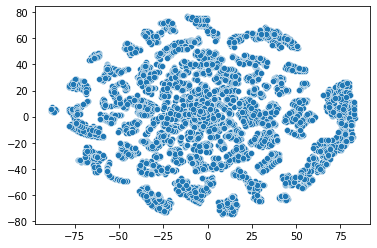

In [25]:
#TSNE 
tsne = sk.TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

sns.scatterplot(node_embeddings_2d[:,0], node_embeddings_2d[:,1])

/Users/wdaugherty/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

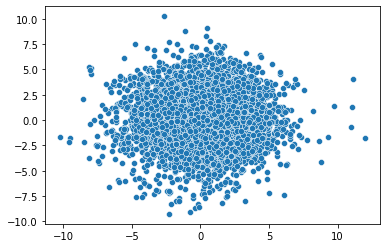

In [26]:
#PCA
pca = skd.PCA(n_components=2)
node_embeddings_2d_2 = pca.fit_transform(node_embeddings)

sns.scatterplot(node_embeddings_2d_2[:,0], node_embeddings_2d_2[:,1])

### KMeans Clustering 

In [27]:

kmeans = skc.KMeans(n_clusters=32, init='k-means++', n_init=10, random_state=0)
kmeans.fit(node_embeddings)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmeans.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered = df_nodes.merge(node_cluster_labels, on='osmid')

KMeans(n_clusters=32, random_state=0)